# Text Analytics - Assignment 2

Grammatikopoulou Maria - f3352310

Phevos A. Margonis - f3352317

Moniaki Melina - f3352321

In [1]:
#%% Imports
# NLP Parsing and Processing - Uncomment if using these libraries
# !pip install conllu
# from catalogue import create
# from conllu import parse_incr
import os
import time
import re
import warnings
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, auc, f1_score, precision_recall_curve, precision_score, recall_score
from sklearn.dummy import DummyClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gensim.downloader as api

rng = default_rng(42)

In [2]:
#%% Load Word2Vec
start_time = time.time()
w2v = api.load('word2vec-google-news-300')
print("Loading ==Word2Vec== took {:.6f} seconds".format(time.time() - start_time))

Loading ==Word2Vec== took 71.174103 seconds


## Parse conllu files. Process and store them as CSVs.

In [3]:
#%% Parsing
# ======= UNCOMMENT TO READ RAW CONLLU FILES =========================================
# %% Parse conllu files
def read_conllu(data_file_path: str) -> list:
    """ Input path to file.
        Return for each text its [tokens, upos]
    """
    docs = []
    # Open the file and parse it
    with open(data_file_path, 'r', encoding='utf-8') as file:
        for tokenlist in tqdm(parse_incr(file), desc="Parsing", unit=" tokenlists"):
            text, pos = ['PAD'], ['X']
            for i in range(len(tokenlist)):
                token = tokenlist[i]
                text.append(token['form'])
                pos.append(token['upos'])
                if i == len(tokenlist)-1:
                    text.append('PAD')
                    pos.append('X')

            docs.append([text, pos])
    return docs


# Read data files
train_data_raw = read_conllu('UD_English-GUM-master/en_gum-ud-train.conllu')
val_data_raw = read_conllu('UD_English-GUM-master/en_gum-ud-dev.conllu')
test_data_raw = read_conllu('UD_English-GUM-master/en_gum-ud-test.conllu')

# %% Process raw data to windows
def create_windows(docs: list) -> pd.DataFrame:
    """ Input: a conllu_data_raw list
        Return: a dataframe [word_left, word_center, word_right, target]
    """

    WINDOW = 3
    OFFSETT = WINDOW - 1
    data = []
    for text, pos in docs:
        # Loop through words
        for i in range(0, len(text)-OFFSETT):
            pair = []
            # Create window for target word
            for j in range(WINDOW):
                pair.append(text[i+j])
            pair.append(pos[i+1])
            data.append(pair)

    return pd.DataFrame(data, columns=['left', 'center', 'right', 'target'])

# Convertion
trainDF = create_windows(train_data_raw)
valDF   = create_windows(val_data_raw)
testDF  = create_windows(test_data_raw)

#%% Store processed data
trainDF.to_csv('en_gum_train.csv', index=False)
valDF.to_csv('en_gum_val.csv', index=False)
testDF.to_csv('en_gum_test.csv', index=False)

In [4]:
#%% Read data
"""
Ta dataset exoun kapoia discrepancies vasi tou splitting convention pou akolouthoun.
Den iparxeei POS Tag '_' ara afairoume oles tis grammes pou exoun tetoio 'target'
"""
trainDF = pd.read_csv('en_gum_train.csv')
trainDF = trainDF[trainDF['target'] != '_'].reset_index(drop=True)
valDF   = pd.read_csv('en_gum_val.csv')
valDF = valDF[valDF['target'] != '_'].reset_index(drop=True)
testDF  = pd.read_csv('en_gum_test.csv')
testDF = testDF[testDF['target'] != '_'].reset_index(drop=True)

In [5]:
#%% Truncate DFs for speed and debugging
# trainDF = trainDF.head(10000)
# valDF = valDF.head(2000)
# testDF = testDF.head(2000)

## Pre-processing

In [6]:
#%% Convert DF words to embeddings
lb = LabelBinarizer()
lb = lb.fit(trainDF.target.tolist())

# Word2Vec does not have embeddings for several target classes.
# Handle Word2Vec OOV words.
custom_embeddings = {
    'PUNCT': rng.normal(0, 0.15, 300).astype('float32'),
    'SYM': rng.normal(-0.001, 0.15, 300).astype('float32'),
    'OOV': np.zeros(300, dtype='float32')
}
# Add DASH embedding as the centroid of PUNCT and SYM embeddings because it can be found as either one of those classes.
custom_embeddings['DASH'] = np.mean([custom_embeddings['PUNCT'], custom_embeddings['SYM']], axis=0)

def convert_data(df, model=w2v, lb=lb, embeddings:dict = custom_embeddings):
    """
    Converts word windows to embeddings.
    
    Parameters
    ----------
    df : DataFrame
        The input df. The first 3 columns contain words that will
        be converted to embeddings and will act as the X matrix.
        The last column contains the labels that will be binarised.
    lb : Method, optional
        The LabelBinarizer. The default is lb.
    embeddings: dict
        The custom embeddings for OOV words.

    Returns
    -------
    matrix : np.array of float32
        The training data. Each row has the word embeddings for this window
        concatenated forming a 900x1 vector.
    labels_1_hot : np.array of float32
        The POS Tags that have been converted to one-hot vectors.
    """

    def convert_to_embedding(model, word:str, embeddings:dict = embeddings):
        """
        Input a word and a Word2Vec model
        Return the word embedding for known words or
        an array of zeros for OOV words
        """
        word = word.lower() # Standardize. Capitalization is inconsequential in this problem.

        if word == 'pad':
            # Handle padding
            embedding = embeddings.get('OOV')
        elif word in w2v.key_to_index:
            # Word found in Word2Vec
            embedding = model[word]
        elif re.match(r'^(of|to)$', word):
            # Missing most common ADPs
            embedding = model['on'] # One of top10 ADPs
        elif word.isdigit():
            # Missing NUMBERS
            embedding = model['2'] # The magnitude of the number is inconsequential.
        elif re.match(r'^[(),\[\].,:“”‘’\'\";\\\\]$', word):
            # Missing PUNCTUATIONS
            embedding = embeddings.get('PUNCT')
        elif word in ['–', '/']:
            # Missing SYMBOLS
            embedding = embeddings.get('SYM')
        elif word == '-':
            # Missing DASH
            embedding = embeddings.get('DASH')
        else:
            # Other OOV words
            embedding = embeddings.get('OOV')

        return embedding

    def concatenate_embeddings(row):
        """ Concatenate the columns of a row in the DF"""
        return np.concatenate(row)

    df = df.copy()
    # Apply the convert_to_embedding on each 'word' element of the df
    df.loc[:, 'left':'right'] = \
        df.loc[:, 'left':'right'].applymap(
            lambda x: convert_to_embedding(model, word=x)
        )
    # Concatenate columns
    matrix = df.apply(lambda row: concatenate_embeddings(row[:3]), axis=1)
    matrix = matrix.to_numpy() # Convert to np arrays
    matrix = np.vstack(matrix) # Conver to np matrix

    labels_1_hot = lb.transform(df.target.tolist())

    return matrix, labels_1_hot

start_time = time.time()
X_train, y_train = convert_data(trainDF)
X_val, y_val = convert_data(valDF)
X_test, y_test = convert_data(testDF)
print("Post-processing ==input-data== took {:.6f} seconds".format(time.time() - start_time))

Post-processing ==input-data== took 21.216515 seconds


In [7]:
#%% Serialize target labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(trainDF.target.values).tolist()
y_val_encoded = encoder.transform(valDF.target.values).tolist()
y_test_encoded = encoder.transform(testDF.target.values).tolist()

TARGET_NAMES = sorted(trainDF.target.unique())

## Baseline: Majority

In [8]:
#%% Majority:Baseline
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train_encoded)

# Evaluate
model = baseline

predictions = model.predict(X_train)
print('===Training===')
print(classification_report(y_train_encoded,
                            predictions,
                            zero_division = 0,
                            labels=list(range(17)),
                            target_names=TARGET_NAMES
                            ))

print('===Validation===')
predictions = model.predict(X_val)
print(classification_report(y_val_encoded,
                            predictions,
                            zero_division = 0,
                            labels=list(range(17)),
                            target_names=TARGET_NAMES
                            ))

print('===Test===')
predictions = model.predict(X_test)
print(classification_report(y_test_encoded,
                            predictions,
                            zero_division = 0,
                            labels=list(range(17)),
                            target_names=TARGET_NAMES
                            ))

#PR-AUC Logistic
def my_multiclass_auc_report(y_true,
                            y_pred,
                            title:str,
                            TARGET_NAMES=TARGET_NAMES) -> None:
    """
    Calculate the Precision-Recall AUC for each class,
    and then their Macro-averaged score.

    Parameters
    ----------
    y_true : np.array of int
        The one-hot label vectors for each data-point.
    y_pred : np.array of float
        The MxN predicted probabilities for each data-point (M) and class (N).
    title : str
        The title of the data-set that is processed. E.g.: Train/Val/Test.

    Returns
    -------
    None

    """
    print(f"=== PR-AUC for {title} ===")
    macro_auc = []
    for i in range(len(TARGET_NAMES)):
        precision, recall, _ = precision_recall_curve(y_true[:,i], y_pred[:,i])
        area = auc(recall, precision)
        print(f"PR-AUC for class {i}: {area*100:.2f}%")
        macro_auc.append(area)

    print(f"-> Macro-averaged PR-AUC: {np.mean(macro_auc)*100:.2f}%\n")

# Predict class probabilities to be used for PR-AUC
predictions_train = model.predict_proba(X_train)
predictions_val = model.predict_proba(X_val)
predictions_test = model.predict_proba(X_test)

# Suppress specific warnings temporarily
warnings.filterwarnings("ignore", message="No positive class found in y_true")
# PR-AUC report
my_multiclass_auc_report(y_train, predictions_train, 'Train')
my_multiclass_auc_report(y_val, predictions_val, 'Validation')
my_multiclass_auc_report(y_test, predictions_test, 'Test')

===Training===
              precision    recall  f1-score   support

         ADJ       0.00      0.00      0.00      9805
         ADP       0.00      0.00      0.00     14064
         ADV       0.00      0.00      0.00      6994
         AUX       0.00      0.00      0.00      7709
       CCONJ       0.00      0.00      0.00      4851
         DET       0.00      0.00      0.00     12072
        INTJ       0.00      0.00      0.00      1347
        NOUN       0.17      1.00      0.29     24689
         NUM       0.00      0.00      0.00      2955
        PART       0.00      0.00      0.00      3474
        PRON       0.00      0.00      0.00     12113
       PROPN       0.00      0.00      0.00      8982
       PUNCT       0.00      0.00      0.00     20620
       SCONJ       0.00      0.00      0.00      2324
         SYM       0.00      0.00      0.00       232
        VERB       0.00      0.00      0.00     15413
           X       0.00      0.00      0.00       306

    accurac

## Baseline: Logistic

In [10]:
#%% Logistic:Baseline
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train_encoded)

# Score
logit_val_accuracy = clf.score(X_val,y_val_encoded)
print(logit_val_accuracy)

# Evaluate Logistic
model = clf

predictions = model.predict(X_train)
print('===Training===')
print(classification_report(y_train_encoded,
                            predictions,
                            zero_division = 0,
                            labels=list(range(17)),
                            target_names=TARGET_NAMES
                            ))

print('===Validation===')
predictions = model.predict(X_val)
print(classification_report(y_val_encoded,
                            predictions,
                            zero_division = 0,
                            labels=list(range(17)),
                            target_names=TARGET_NAMES
                            ))

print('===Test===')
predictions = model.predict(X_test)
print(classification_report(y_test_encoded,
                            predictions,
                            zero_division = 0,
                            labels=list(range(17)),
                            target_names=TARGET_NAMES
                            ))

# Predict class probabilities to be used for PR-AUC
predictions_train = model.predict_proba(X_train)
predictions_val = model.predict_proba(X_val)
predictions_test = model.predict_proba(X_test)

# Suppress specific warnings temporarily
warnings.filterwarnings("ignore", message="No positive class found in y_true")
# PR-AUC report
my_multiclass_auc_report(y_train, predictions_train, 'Train')
my_multiclass_auc_report(y_val, predictions_val, 'Validation')
my_multiclass_auc_report(y_test, predictions_test, 'Test')

0.9198595634254312
===Training===
              precision    recall  f1-score   support

         ADJ       0.90      0.89      0.90      9805
         ADP       0.96      0.98      0.97     14064
         ADV       0.91      0.91      0.91      6994
         AUX       0.97      0.98      0.97      7709
       CCONJ       0.82      0.89      0.85      4851
         DET       0.95      0.96      0.96     12072
        INTJ       0.91      0.79      0.84      1347
        NOUN       0.90      0.93      0.92     24689
         NUM       0.98      0.96      0.97      2955
        PART       0.96      0.90      0.93      3474
        PRON       0.99      0.99      0.99     12113
       PROPN       0.78      0.73      0.75      8982
       PUNCT       0.98      0.98      0.98     20620
       SCONJ       0.91      0.82      0.86      2324
         SYM       0.94      0.75      0.84       232
        VERB       0.94      0.94      0.94     15413
           X       0.88      0.34      0.49    

## MLP

In [9]:
#%% MLP: Metrics
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {} # Dictionary {Metric: Value}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]

        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)

        _val_f1 = f1_score(val_targ, val_predict, average="weighted",
                           zero_division=1)
        _val_recall = recall_score(val_targ, val_predict, average="weighted",
                                   zero_division=1)
        _val_precision = precision_score(val_targ, val_predict, average="weighted",
                                         zero_division=1)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return


In [10]:
#%% MLP RUN
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Sequential API after tunner
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128,  activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(len(trainDF.target.unique()),  activation='softmax'))

print(model.summary())

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
    )
if not os.path.exists('./checkpoints'):
  os.makedirs('./checkpoints')
# Callback to save the Keras model or model weights at some frequency.
checkpoint = ModelCheckpoint(
    'checkpoints/weights_ex10.hdf5',
    monitor='val_accuracy',
    mode='max',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )
start_training_time = time.time()

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=256,
    epochs=100,
    shuffle=True, # Shuffle the train data on every epoch
    callbacks=[Metrics(valid_data=(X_val, y_val)), checkpoint, early_stopping]
    )
end_training_time = time.time()

print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} \n')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               115328    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 17)                2193      
                                                                 
Total params: 134033 (523.57 KB)
Trainable params: 134033 (523.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10

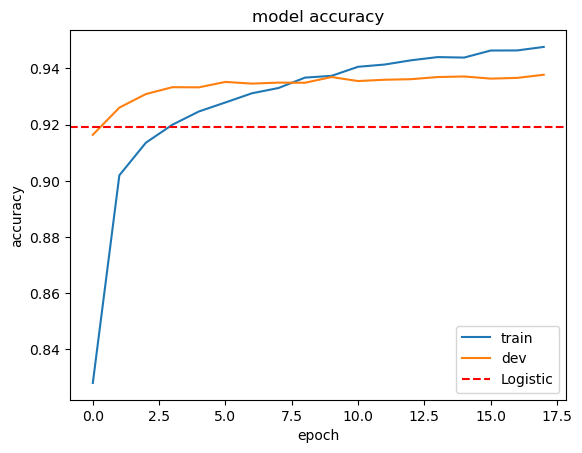

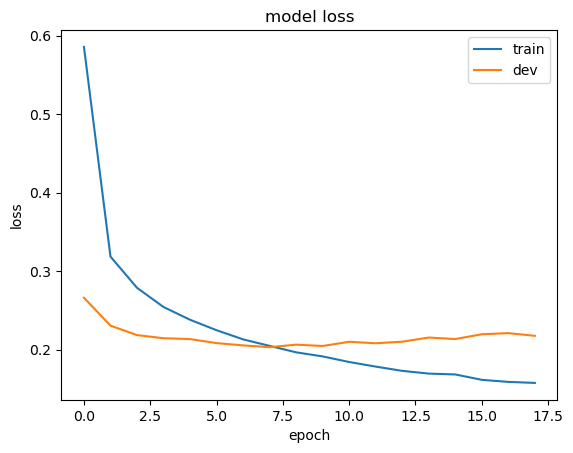

In [11]:
#%% Curves
# history: Returned by the fit. Keeps the metrics for each epoch
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.axhline(y=logit_val_accuracy, color='red', linestyle='--', label='Logistic')
plt.legend(['train', 'dev', 'Logistic'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [12]:
#%% Evaluation
TARGET_NAMES = sorted(trainDF.target.unique())

predictions = np.argmax(model.predict(X_train), -1)
print(classification_report(y_train_encoded,
                            predictions,
                            zero_division = 0,
                            labels=list(range(len(TARGET_NAMES))),
                            target_names=TARGET_NAMES))
predictions = np.argmax(model.predict(X_val), -1)
print(classification_report(y_val_encoded,
                            predictions,
                            zero_division = 0,
                            labels=list(range(len(TARGET_NAMES))),
                            target_names=TARGET_NAMES))
predictions = np.argmax(model.predict(X_test), -1)
print(classification_report(y_test_encoded,
                            predictions,
                            zero_division = 0,
                            labels=list(range(len(TARGET_NAMES))),
                            target_names=TARGET_NAMES))

4624/4624 [==============================] - 7s 2ms/step
              precision    recall  f1-score   support

         ADJ       0.96      0.98      0.97      9805
         ADP       0.98      0.99      0.99     14064
         ADV       0.98      0.94      0.96      6994
         AUX       0.99      0.99      0.99      7709
       CCONJ       0.93      0.94      0.93      4851
         DET       0.99      0.99      0.99     12072
        INTJ       0.89      0.87      0.88      1347
        NOUN       0.96      0.98      0.97     24689
         NUM       0.99      0.97      0.98      2955
        PART       0.99      0.97      0.98      3474
        PRON       0.99      1.00      0.99     12113
       PROPN       0.89      0.88      0.88      8982
       PUNCT       0.99      0.99      0.99     20620
       SCONJ       0.96      0.91      0.94      2324
         SYM       0.96      0.83      0.89       232
        VERB       0.98      0.98      0.98     15413
           X       0.97 

In [13]:
#%% PR-AUC
# Predict class probabilities to be used for PR-AUC
predictions_train = model.predict(X_train)
predictions_val = model.predict(X_val)
predictions_test = model.predict(X_test)

# Suppress specific warnings temporarily
warnings.filterwarnings("ignore", message="No positive class found in y_true")

# PR-AUC report
my_multiclass_auc_report(y_train, predictions_train, 'Train')
my_multiclass_auc_report(y_val, predictions_val, 'Validation')
my_multiclass_auc_report(y_test, predictions_test, 'Test')

623/623 [==============================] - 1s 2ms/step
=== PR-AUC for Train ===
PR-AUC for class 0: 99.51%
PR-AUC for class 1: 99.90%
PR-AUC for class 2: 99.45%
PR-AUC for class 3: 99.89%
PR-AUC for class 4: 98.41%
PR-AUC for class 5: 99.90%
PR-AUC for class 6: 93.82%
PR-AUC for class 7: 99.47%
PR-AUC for class 8: 99.46%
PR-AUC for class 9: 99.58%
PR-AUC for class 10: 99.98%
PR-AUC for class 11: 95.75%
PR-AUC for class 12: 99.93%
PR-AUC for class 13: 98.25%
PR-AUC for class 14: 92.83%
PR-AUC for class 15: 99.78%
PR-AUC for class 16: 67.47%
-> Macro-averaged PR-AUC: 96.67%

=== PR-AUC for Validation ===
PR-AUC for class 0: 96.99%
PR-AUC for class 1: 99.16%
PR-AUC for class 2: 96.27%
PR-AUC for class 3: 99.50%
PR-AUC for class 4: 91.63%
PR-AUC for class 5: 99.26%
PR-AUC for class 6: 89.16%
PR-AUC for class 7: 97.41%
PR-AUC for class 8: 98.71%
PR-AUC for class 9: 96.84%
PR-AUC for class 10: 99.90%
PR-AUC for class 11: 83.59%
PR-AUC for class 12: 99.76%
PR-AUC for class 13: 89.39%
PR-AUC f

In [ ]:
#%% Tuner

# # !pip install -U keras-tuner
# import keras_tuner as kt
# from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()

    layer_index = 0
    for i in range(hp.Int(name='num_layers',min_value=1,max_value=3)):
        if layer_index == 0:
            model.add(Dense(hp.Int(name='hidden_units_'+str(i),
                                   min_value=64,
                                   max_value=512,
                                   step=64),
                            activation=hp.Choice(name='activation_layer'+str(i),
                                                 values=['relu','tanh']),
                            input_dim=X_train.shape[1]
                            ))
            model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5])))
        else:
            model.add(Dense(hp.Int(name='hidden_units_'+str(i),
                                   min_value=64,
                                   max_value=512,
                                   step=64),
                            activation=hp.Choice(name='activation_layer'+str(i),
                                                 values=['relu','tanh'])))
            model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5])))

        layer_index += 1

    # Add last layer that produces the logits
    model.add(Dense(len(trainDF.target.unique()),  activation='softmax')) # To output layer prepei na exei tosous nevrones oses kai oi katigories mas # Softmax: logo Multiclass

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=hp_learning_rate),
        metrics=['accuracy'])

    return model

tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=30,
                        directory='KT_dir',
                        project_name='KT_tuning')

early_stopping = EarlyStopping(monitor='val_loss',
                                patience=10)

# tuner.search_space_summary()

tuner.search(X_train,
             y_train,
             validation_data=(X_val, y_val),
             epochs=100,
             batch_size = 256,
             callbacks=[early_stopping, checkpoint])

# Get best hyper-parameters setup
tuner.get_best_hyperparameters()[0].values

best_model = tuner.get_best_models(num_models=1)[0]
tuner.get_best_hyperparameters()[0].values
best_model.summary()

#%% Evaluate best
predictions = np.argmax(best_model.predict(X_val), -1)
print(classification_report(y_val_encoded,
                            predictions,
                            zero_division = 0,
                            labels=list(range(len(TARGET_NAMES))),
                            target_names=TARGET_NAMES))